### Import library dan data yang akan digunakan

In [444]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
sns.set()

In [445]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
contoh = pd.read_csv("gender_submission.csv")

In [446]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [447]:
train.shape

(891, 12)

In [448]:
print("Data Train")
train.info()
print("\n\nData Test")
test.info()

Data Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Data Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

In [449]:
# ''' Terdapat 12 kolom yang terdiri dari:
#     1. PassengerID, berisi nomor id dari masing-masing penumpang.
#     2. Survived, keterangan bahwa penumpang selamat(1) atau tidak(0).
#     3. Pclass, kelas penumpang.
#     4. Name, nama-nama dari penumpang.
#     5. Sex, jenis kelamin penumpang.
#     6. Age, umur penumpang.
#     7. SibSp, banyak saudara dari penumpang pada kapal.
#     8. Parch, banyak orang tua / anak dari penumpang pada kapal.
#     9. Ticket, nomor tiket milik penumpang.
#     10. Fare, tarif setiap penumpang.
#     11. Cabin, kabin yang ditempati penumpang.
#     12. Embarked, pelabuhan asal saat memulai perjalanan.
# '''

In [450]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [451]:
train.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fynney, Mr. Joseph J",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


### Membersihkan, merapihkan & menampilkan grafik data

In [452]:
# Fungsi grafik untuk atribut diskrit
def bar_chart(x, y):
    i = x[x["Survived"]==1][y].value_counts()
    j = x[x["Survived"]==0][y].value_counts()
    df = pd.DataFrame([i, j])
    df.index = ["Selamat","Meninggal"]
    df.plot(kind="bar", stacked=False, figsize=(10,5), rot=0)

In [453]:
# Fungsi grafik untuk atribut kontinyu
def facetgrid(data, col):
    facet = sns.FacetGrid(data, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, col, shade=True)
    facet.set(xlim=(0, data[col].max()))
    facet.add_legend()
    plt.xlim()

In [454]:
# Mencari outliers dari atribut-atribut bernilai kontinyu
def detect_outliers(df,n,features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
    return multiple_outliers

In [455]:
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [456]:
train = train.drop(Outliers_to_drop, axis = 0)

In [457]:
train_test = [train, test]

In [458]:
#####

In [459]:
train.Pclass.value_counts()

3    484
1    213
2    184
Name: Pclass, dtype: int64

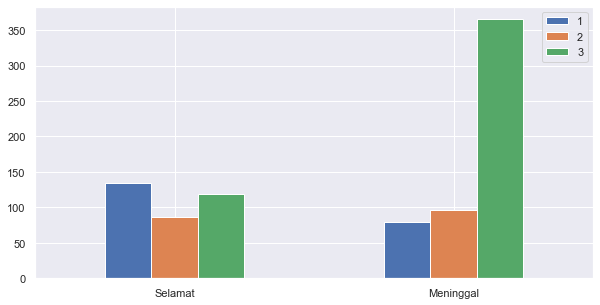

In [460]:
bar_chart(train, "Pclass")

In [461]:
train.Embarked.value_counts()

S    634
C    168
Q     77
Name: Embarked, dtype: int64

In [462]:
for dataset in train_test:
    dataset["Embarked"] = dataset["Embarked"].map({"S":0, "C":1, "Q":2})

In [463]:
train["Embarked"].fillna(train.groupby("Pclass")["Embarked"].transform("median"), inplace = True)

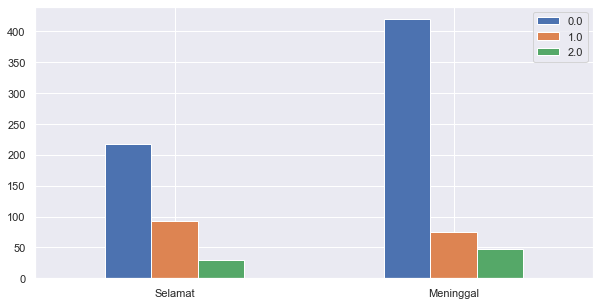

In [464]:
bar_chart(train, "Embarked")

In [465]:
train.Sex.value_counts()

male      572
female    309
Name: Sex, dtype: int64

In [466]:
for dataset in train_test:
    dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

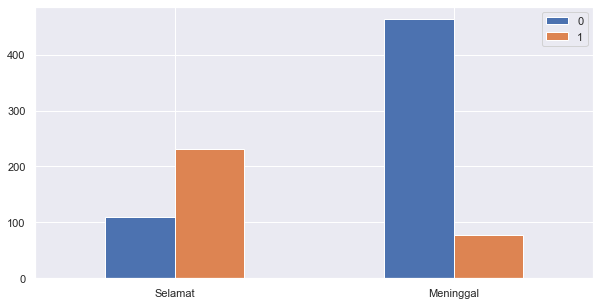

In [467]:
bar_chart(train, "Sex")

In [468]:
for dataset in train_test:
    dataset["Title"] = dataset["Name"].str.extract(" ([A-Za-z]+)\.", expand = False)

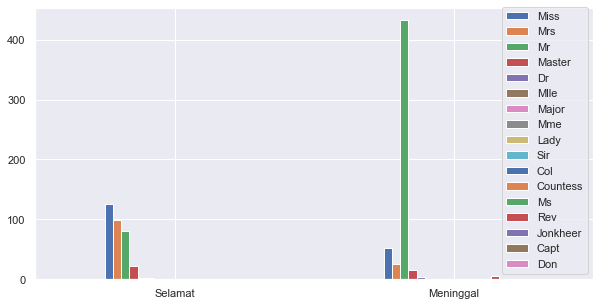

In [469]:
bar_chart(train, "Title")

In [470]:
for dataset in train_test:
    dataset["Title"] = dataset["Title"].map({"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Rev":4, "Dr":4, 
                                             "Col":5, "Dona":5, "Ms":5, "Major":5, "Mlle":5, "Mme":5,
                                             "Countess":5, "Jonkheer":5, "Capt":5, "Sir":5, "Don":5, 
                                             "Lady":5})

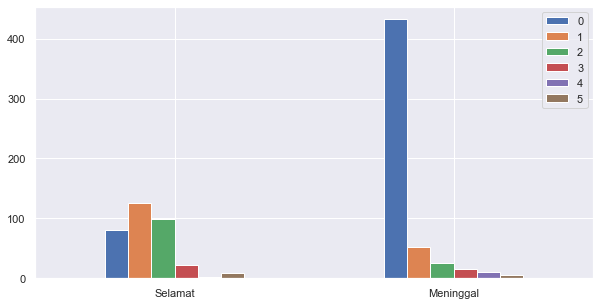

In [471]:
bar_chart(train, "Title")

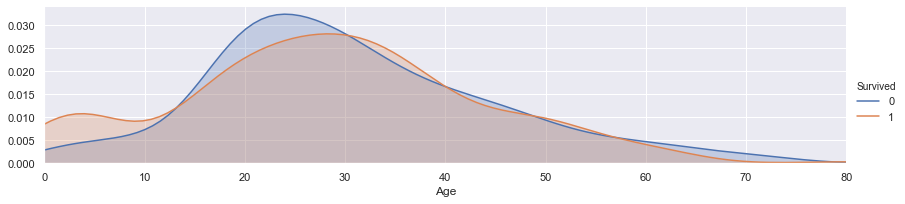

In [472]:
facetgrid(train, "Age")

In [473]:
train["Age"].fillna(train.groupby("Pclass")["Age"].transform("median"), inplace = True)
test["Age"].fillna(test.groupby("Pclass")["Age"].transform("median"), inplace = True)

In [474]:
# Mengikuti Standar WHO

for dataset in train_test:
    dataset.loc[dataset["Age"] <= 1, "Age"] = 0, # Bayi
    dataset.loc[(dataset["Age"] > 1) & (dataset["Age"] <= 10), "Age"] = 1, # Anak-anak
    dataset.loc[(dataset["Age"] > 10) & (dataset["Age"] <= 19), "Age"] = 2, # Remaja
    dataset.loc[(dataset["Age"] > 19) & (dataset["Age"] <= 60), "Age"] = 3, # Dewasa
    dataset.loc[dataset["Age"] > 60, "Age"] = 4, # Lansia

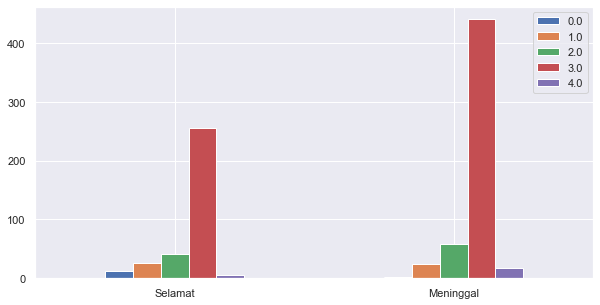

In [475]:
bar_chart(train, "Age")

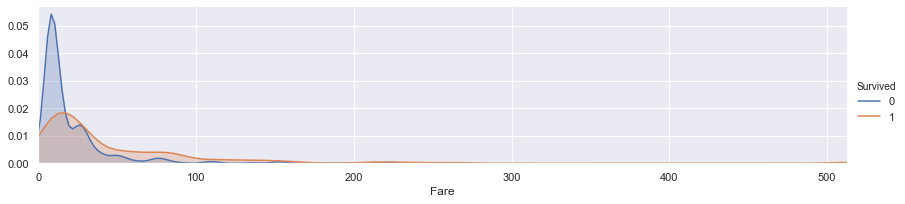

In [476]:
facetgrid(train, "Fare")

In [477]:
test["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("mean"), inplace = True)

In [478]:
for dataset in train_test:
    dataset.loc[dataset["Fare"] <= 8, "Fare"] = 0,
    dataset.loc[(dataset["Fare"] >8) & (dataset["Fare"] <=15), "Fare"] = 1,
    dataset.loc[(dataset["Fare"] >15) & (dataset["Fare"] <=31), "Fare"] = 2,
    dataset.loc[(dataset["Fare"] >31) & (dataset["Fare"] <=100), "Fare"] = 3,
    dataset.loc[dataset["Fare"] >100, "Fare"] = 4

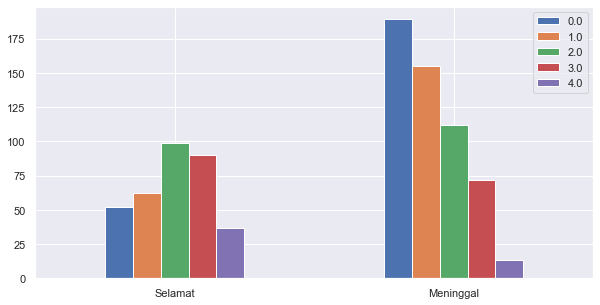

In [479]:
bar_chart(train, "Fare")

In [480]:
train.Parch.value_counts()

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

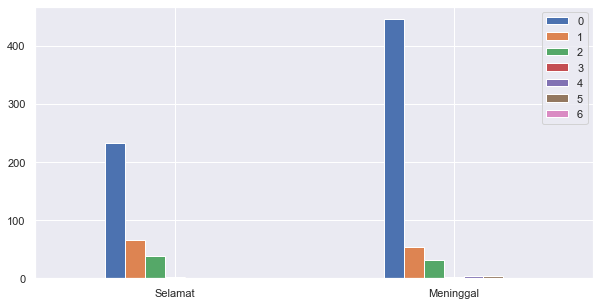

In [481]:
bar_chart(train, "Parch")

In [482]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

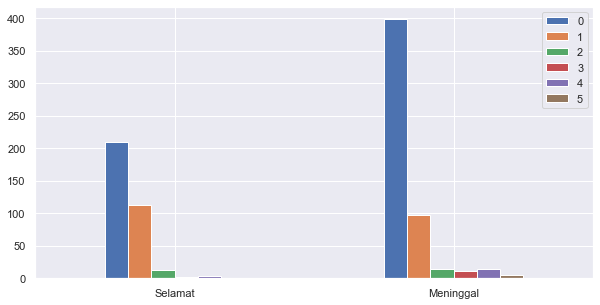

In [483]:
bar_chart(train, "SibSp")

In [484]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

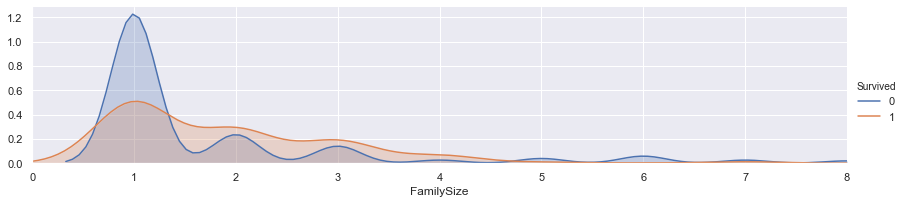

In [485]:
facetgrid(train, "FamilySize")

In [486]:
for dataset in train_test:
    dataset["FamilySize"] = dataset["FamilySize"].map({1:0, 2:0.4, 3:0.8, 4:1.2, 5:1.6, 6:2, 
                                                       7:2.4, 8:2.8, 9:3.2, 10:3.6, 11:4})

In [487]:
# Menghapus kolom yang tidak digunakan dalam pemodelan

train = train.drop(["Cabin", "Name", "SibSp", "Parch", "PassengerId", "Ticket"], axis=1)
testx = test.drop(["Cabin", "Name", "SibSp", "Parch", "PassengerId", "Ticket"], axis=1)

In [488]:
train = train.reset_index(drop=True)

### Transformasi, pemodelan, dan evaluasi pada data

In [489]:
trainx = train.drop("Survived", axis=1)
trainy = train["Survived"]

In [490]:
scaler = StandardScaler().fit(trainx)

scaled_train = scaler.transform(trainx)
scaled_y = scaler.transform(testx)

scaled_train = pd.DataFrame(scaled_train, columns=trainx.columns)
scaled_y = pd.DataFrame(scaled_y, columns=testx.columns)

scaled_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0.829632,-0.734990,0.372394,-1.225794,-0.573110,-0.681971,0.131479
1,-1.566780,1.360563,0.372394,1.219318,0.994933,1.122283,0.131479
2,0.829632,1.360563,0.372394,-1.225794,-0.573110,0.220156,-0.592476
3,-1.566780,1.360563,0.372394,1.219318,-0.573110,1.122283,0.131479
4,0.829632,-0.734990,0.372394,-0.410757,-0.573110,-0.681971,-0.592476


In [491]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, trainy, test_size=0.2, random_state=20)

In [492]:
# List Hyperparameters yang ingin diatur.
# leaf_size = list(range(1,30))
# n_neighbors = list(range(1,15))
# p=[1,2]

# Jadikan ke dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# knn = KNeighborsClassifier()
# clf = GridSearchCV(knn, hyperparameters, cv=10)

In [493]:
knn2 = KNeighborsClassifier(leaf_size=3, n_neighbors=10, p=2)
cross_val_score(knn2, X_train, y_train, scoring="accuracy").mean()

0.8252482269503547

In [494]:
model = KNeighborsClassifier(leaf_size= 3, n_neighbors= 10, p= 2).fit(X_train, y_train)

In [495]:
y_pred = model.predict(X_test)

In [496]:
# Hasil Prediksi model
print("KNN")
print (classification_report(y_test, y_pred))

KNN
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       115
           1       0.74      0.56      0.64        62

    accuracy                           0.78       177
   macro avg       0.77      0.73      0.74       177
weighted avg       0.78      0.78      0.77       177



In [497]:
roc_auc_score(y_test, y_pred)

0.7300841514726508

### Mengaplikasikan model dengan data test

In [502]:
model_pred = RandomForestClassifier(n_estimators=200).fit(trainx, trainy)
hasil_predik = model_pred.predict(testx)

In [503]:
submission = pd.DataFrame({
    "PassengerId":test["PassengerId"],
    "Survived":hasil_predik
})

submission.to_csv("titanic_submission.csv", index=False)